In [354]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, roc_curve, auc
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.dummy import DummyClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, AdaBoostClassifier
import numpy as np
import itertools
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.multiclass import OneVsRestClassifier

sns.set_style('darkgrid')

In [320]:
data = pd.read_csv('music_data_model.csv')

In [321]:
cols = ['name',
       'danceability', 'energy', 'key_', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'duration_ms', 'time_signature', 'number_sections', 'avg_duration',
       'std_duration', 'std_loudness', 'std_tempo', 'number_keys']
df1 = data[cols]

In [332]:
df1.dropna(inplace=True)

/Users/marshall132/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [333]:
X = df1.drop('name', axis=1)
y = df1['name']


In [334]:
X['key_'] = X['key_'].astype('category')

In [335]:
X.dtypes

danceability         float64
energy               float64
key_                category
loudness             float64
mode                 float64
speechiness          float64
acousticness         float64
instrumentalness     float64
liveness             float64
valence              float64
tempo                float64
duration_ms          float64
time_signature       float64
number_sections        int64
avg_duration         float64
std_duration         float64
std_loudness         float64
std_tempo            float64
number_keys          float64
dtype: object

In [336]:
data = pd.get_dummies(X)

In [297]:
X_train, X_test, y_train, y_test = train_test_split(data, y, test_size= .25, random_state = 123)

## Create Base Model

In [220]:
dummy_clf = DummyClassifier(strategy='stratified')
dummy_clf.fit(X_train, y_train)

preds = dummy_clf.predict(X_test)
confusion_matrix(y_test, preds)

array([[17, 23, 12,  8,  5, 11, 16],
       [14, 18, 12, 10,  2, 15, 27],
       [15, 16,  9,  2,  5,  2,  3],
       [ 3,  8,  6,  3,  2,  1,  7],
       [ 3,  4,  3,  3,  2,  0,  6],
       [ 5,  6,  4,  7,  1,  7, 11],
       [15, 14, 14,  5,  3, 15, 10]])

In [221]:
accuracy_score(y_test, preds)

0.16097560975609757

Confusion Matrix, without normalization
[[17 23 12  8  5 11 16]
 [14 18 12 10  2 15 27]
 [15 16  9  2  5  2  3]
 [ 3  8  6  3  2  1  7]
 [ 3  4  3  3  2  0  6]
 [ 5  6  4  7  1  7 11]
 [15 14 14  5  3 15 10]]
                       precision    recall  f1-score   support

    Bruce Springsteen       0.24      0.18      0.21        92
        Fleetwood Mac       0.20      0.18      0.19        98
                JAY-Z       0.15      0.17      0.16        52
           Kanye West       0.08      0.10      0.09        30
       Kendrick Lamar       0.10      0.10      0.10        21
Red Hot Chili Peppers       0.14      0.17      0.15        41
   The Rolling Stones       0.12      0.13      0.13        76

             accuracy                           0.16       410
            macro avg       0.15      0.15      0.15       410
         weighted avg       0.17      0.16      0.16       410



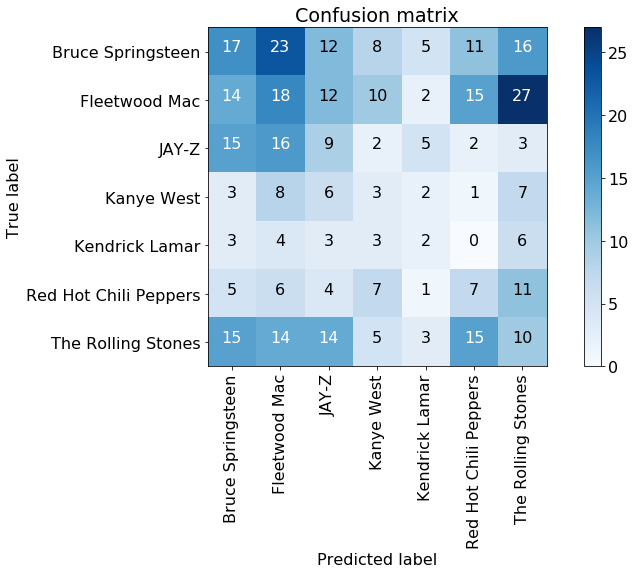

In [262]:
cm = confusion_matrix(y_test, preds)
classes = ['Bruce Springsteen', 'Fleetwood Mac','JAY-Z',
       'Kanye West','Kendrick Lamar' , 'Red Hot Chili Peppers',
       'The Rolling Stones']
plot_confusion_matrix(cm, classes)
print(classification_report(y_test, preds))

## Fit initial Random Forest Classifier without any hyperparameter tuning

In [243]:
forest = RandomForestClassifier(n_estimators=100, max_depth= 5)
forest.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=5, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [244]:
forest.score(X_train, y_train)

0.738599348534202

In [245]:
y_preds = forest.predict(X_test)

In [246]:
forest.score(X_test, y_test)

0.6439024390243903

In [276]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion Matrix, without normalization')

    print(cm)
    
    plt.figure(figsize=(12,8))
    plt.rcParams.update({'font.size': 16})
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion Matrix, without normalization
[[57 26  0  0  1  0  8]
 [11 79  0  0  0  2  6]
 [ 1  1 47  1  0  1  1]
 [ 5  2 10  9  1  2  1]
 [ 1  0 16  2  2  0  0]
 [ 4  4  2  0  0 22  9]
 [13 13  0  0  0  2 48]]
                       precision    recall  f1-score   support

    Bruce Springsteen       0.62      0.62      0.62        92
        Fleetwood Mac       0.63      0.81      0.71        98
                JAY-Z       0.63      0.90      0.74        52
           Kanye West       0.75      0.30      0.43        30
       Kendrick Lamar       0.50      0.10      0.16        21
Red Hot Chili Peppers       0.76      0.54      0.63        41
   The Rolling Stones       0.66      0.63      0.64        76

             accuracy                           0.64       410
            macro avg       0.65      0.56      0.56       410
         weighted avg       0.65      0.64      0.62       410



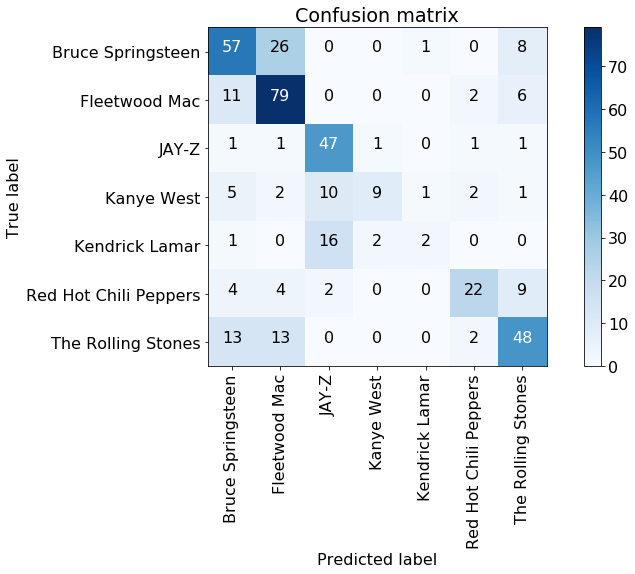

In [261]:
cm = confusion_matrix(y_test, y_preds)
classes = ['Bruce Springsteen', 'Fleetwood Mac','JAY-Z',
       'Kanye West','Kendrick Lamar' , 'Red Hot Chili Peppers',
       'The Rolling Stones']
plot_confusion_matrix(cm, classes)
print(classification_report(y_test, y_preds))

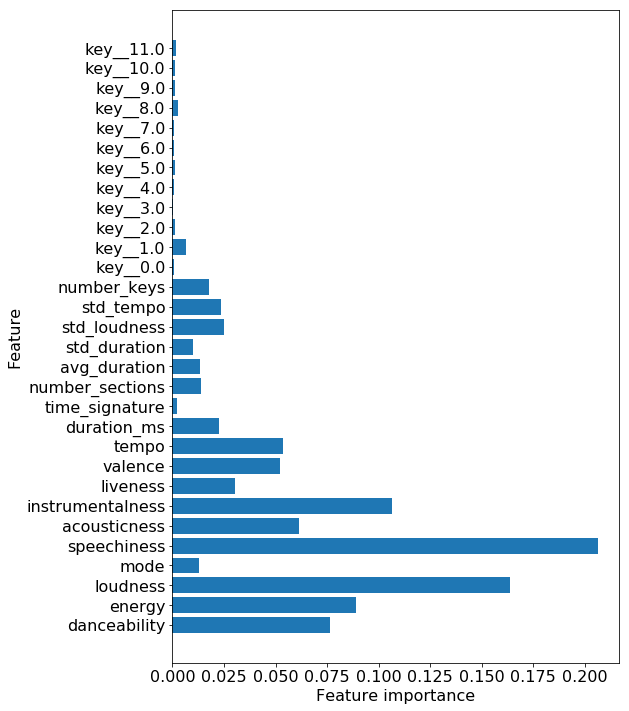

In [278]:
def plot_feature_importances(model):
    n_features = X_train.shape[1]
    plt.figure(figsize=(8,12))
    plt.barh(range(n_features), model.feature_importances_, align='center') 
    plt.yticks(np.arange(n_features), X_train.columns.values) 
    plt.xlabel('Feature importance')
    plt.ylabel('Feature')

plot_feature_importances(forest)

## Re-run Random Forest with hyperparameter tuning

In [103]:
rf_mean_cv_score_train = np.mean(cross_val_score(forest, X_train, y_train))
rf_mean_cv_score_train

/Users/marshall132/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


0.5928913636652072

In [173]:
rf_param_grid = {'n_estimators' : [20, 40, 60, 80, 100, 120, 150,200],
                'criterion' : ['gini', 'entropy'],
                'max_depth' : [1,3,5,7],
                'min_samples_split' : [5,10,15,20],
                 'max_features' : ['sqrt','log2'],
                'min_samples_leaf': [5, 10, 20]}
rf_grid_search = GridSearchCV(forest, rf_param_grid, cv=5)

rf_grid_search.fit(X_train, y_train)

/Users/marshall132/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=5,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              ra..._state=None, verbose=0,
                                              warm_start=False),
             iid='warn'

In [174]:
print(f"Training Accuracy: {rf_grid_search.best_score_}")
print(f"Optimal Parameters: {rf_grid_search.best_params_}")

Training Accuracy: 0.6425081433224755
Optimal Parameters: {'criterion': 'gini', 'max_depth': 7, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 5, 'n_estimators': 150}


### Now let's see how these new parameters affect our test data

In [268]:
forest2 = RandomForestClassifier(criterion='gini',
                                 max_depth= 7,
                                 min_samples_leaf= 5,
                                 min_samples_split= 5,
                                 n_estimators=150,
                                 max_features='sqrt'
                                )
forest2.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=7, max_features='sqrt', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, n_estimators=150,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [269]:
forest2.score(X_train, y_train)

0.8436482084690554

In [270]:
preds2 = forest2.predict(X_test)
accuracy_score(y_test, preds2)

0.6902439024390243

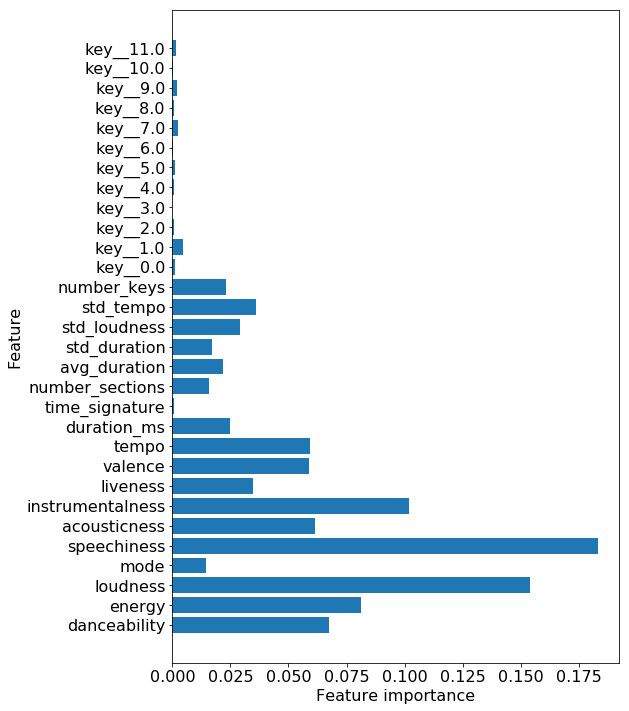

In [279]:
plot_feature_importances(forest2)

Confusion Matrix, without normalization
[[61 22  0  0  1  1  7]
 [12 79  0  0  0  2  5]
 [ 0  0 47  3  0  2  0]
 [ 3  2  9  9  2  4  1]
 [ 0  1 15  3  1  1  0]
 [ 3  4  1  0  0 29  4]
 [ 6 11  0  0  0  2 57]]
                       precision    recall  f1-score   support

    Bruce Springsteen       0.72      0.66      0.69        92
        Fleetwood Mac       0.66      0.81      0.73        98
                JAY-Z       0.65      0.90      0.76        52
           Kanye West       0.60      0.30      0.40        30
       Kendrick Lamar       0.25      0.05      0.08        21
Red Hot Chili Peppers       0.71      0.71      0.71        41
   The Rolling Stones       0.77      0.75      0.76        76

             accuracy                           0.69       410
            macro avg       0.62      0.60      0.59       410
         weighted avg       0.67      0.69      0.67       410



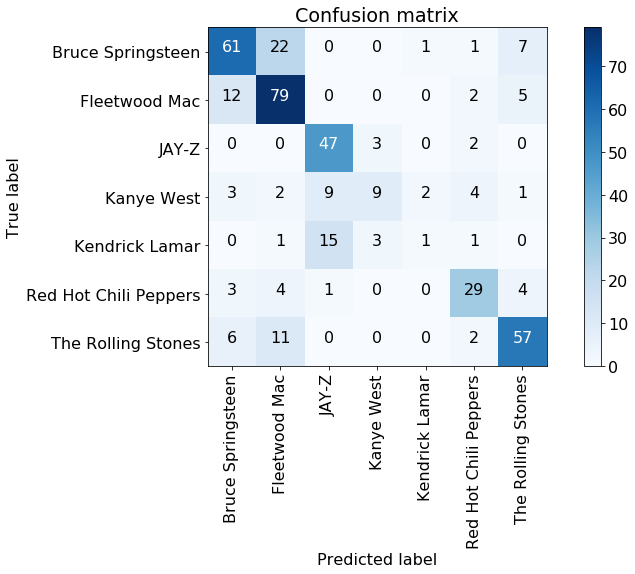

In [273]:
cm = confusion_matrix(y_test, preds2)
classes = ['Bruce Springsteen', 'Fleetwood Mac','JAY-Z',
       'Kanye West','Kendrick Lamar' , 'Red Hot Chili Peppers',
       'The Rolling Stones']
plot_confusion_matrix(cm, classes)
print(classification_report(y_test, preds2))

#### Test model performance did not improve when using the optimized features from the grid search, even though the training score improved significantly. 

## Now let's try a few weak learning methods, Adaboost and Gradientboost, to see if other techniques impove model performance

In [211]:
adaboost_clf = AdaBoostClassifier(random_state = 42)

In [212]:
adaboost_clf.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=50, random_state=42)

#### Not looking so good for Adaboost...

In [213]:
y_preds = adaboost_clf.predict(X_test)
accuracy_score(y_test, y_preds)

0.43658536585365854

#### We might have some hope with Gradientboost!

In [149]:
gbt_clf = GradientBoostingClassifier(random_state=42)#random_state = 42)
gbt_clf.fit(X_train, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='auto',
                           random_state=42, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [151]:
preds = gbt_clf.predict(X_test)
accuracy_score(y_test, preds)


0.7073170731707317

#### However this model is extrmeley overfit to the training data

In [152]:
gbt_clf.score(X_train, y_train)

0.992671009771987

### Maybe we can improve model performance through hyperparameter tuning and cross validation

In [169]:
grid = {'learning_rate' : [.05,.075,.1],
       'n_estimators' : [120,140, 160, 180, 200],
       'max_depth': [1,3,5]
       }
gs = GridSearchCV(gbt_clf, grid, cv=5)

gs.fit(X_train, y_train)

/Users/marshall132/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=GradientBoostingClassifier(criterion='friedman_mse',
                                                  init=None, learning_rate=0.1,
                                                  loss='deviance', max_depth=3,
                                                  max_features=None,
                                                  max_leaf_nodes=None,
                                                  min_impurity_decrease=0.0,
                                                  min_impurity_split=None,
                                                  min_samples_leaf=1,
                                                  min_samples_split=2,
                                                  min_weight_fraction_leaf=0.0,
                                                  n_estimators=120,
                                                  n_iter_no_change=None,
                                                  presort=

In [229]:
print(f"Cross Validation Accuracy: {gs.best_score_}")
print(f"Optimal Parameters: {gs.best_params_}")

Cross Validation Accuracy: 0.6815960912052117
Optimal Parameters: {'learning_rate': 0.075, 'max_depth': 5, 'n_estimators': 160}


In [214]:
gbt_clf2 = GradientBoostingClassifier(random_state=42, learning_rate=0.075, max_depth=5, n_estimators=160)#random_state = 42)
gbt_clf2.fit(X_train, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.075, loss='deviance', max_depth=5,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=160,
                           n_iter_no_change=None, presort='auto',
                           random_state=42, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

#### Unfortunately, this method still results in a severely overfitted model

In [215]:
gbt_clf2.score(X_train, y_train)
preds1 = gbt_clf2.predict(X_train)
print(classification_report(y_train, preds1))

                       precision    recall  f1-score   support

    Bruce Springsteen       1.00      1.00      1.00       246
        Fleetwood Mac       1.00      1.00      1.00       292
                JAY-Z       1.00      1.00      1.00       160
           Kanye West       1.00      1.00      1.00       102
       Kendrick Lamar       1.00      1.00      1.00        64
Red Hot Chili Peppers       1.00      1.00      1.00       147
   The Rolling Stones       1.00      1.00      1.00       217

             accuracy                           1.00      1228
            macro avg       1.00      1.00      1.00      1228
         weighted avg       1.00      1.00      1.00      1228



## Free SMOTE

In [231]:
X_resampled, y_resampled = SMOTE().fit_resample(X_train, y_train)

In [241]:
np.unique(y_resampled, return_counts=True)

(array(['Bruce Springsteen', 'Fleetwood Mac', 'JAY-Z', 'Kanye West',
        'Kendrick Lamar', 'Red Hot Chili Peppers', 'The Rolling Stones'],
       dtype=object), array([292, 292, 292, 292, 292, 292, 292]))

In [232]:
forest_smote = RandomForestClassifier(n_estimators=100, max_depth= 5)
forest_smote.fit(X_resampled, y_resampled)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=5, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

Confusion Matrix, without normalization
[[58 24  0  1  0  0  9]
 [10 80  0  0  0  1  7]
 [ 0  1 47  1  0  2  1]
 [ 5  2 11  9  1  1  1]
 [ 1  1 15  2  1  1  0]
 [ 2  5  2  0  0 25  7]
 [ 8 12  0  0  0  2 54]]
                       precision    recall  f1-score   support

    Bruce Springsteen       0.67      0.65      0.66        92
        Fleetwood Mac       0.71      0.73      0.72        98
                JAY-Z       0.73      0.77      0.75        52
           Kanye West       0.45      0.33      0.38        30
       Kendrick Lamar       0.36      0.38      0.37        21
Red Hot Chili Peppers       0.62      0.85      0.72        41
   The Rolling Stones       0.80      0.67      0.73        76

             accuracy                           0.67       410
            macro avg       0.62      0.63      0.62       410
         weighted avg       0.67      0.67      0.67       410



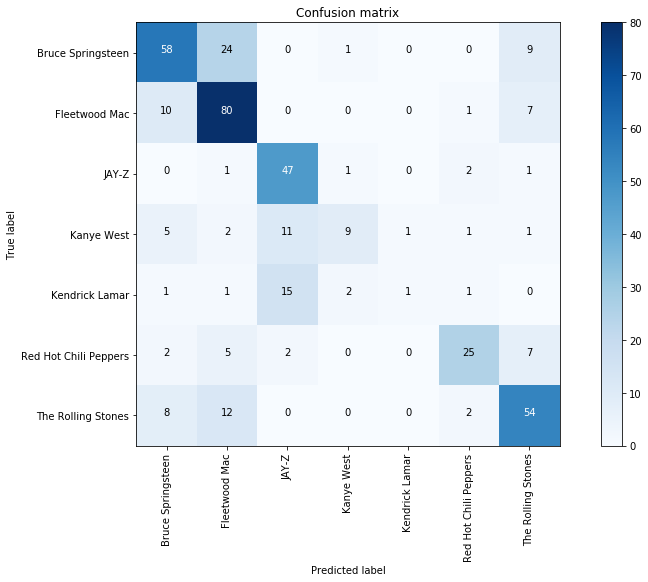

In [233]:
smote_preds = forest_smote.predict(X_test)
plot_confusion_matrix(cm, classes)
print(classification_report(y_test, smote_preds))

### Unfortunately re-sampling our data doesn't improve the accuracy of our model

In [358]:
from sklearn import preprocessing
lb = preprocessing.LabelBinarizer()

y_binarize = lb.fit_transform(y)
y_binarize

array([[0, 1, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 1],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 1],
       [1, 0, 0, ..., 0, 0, 0]])

In [369]:
y_binarize = label_binarize(y, classes=y.unique())
n_classes = y_bin.shape[1]

In [338]:
y_bin

array([[1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 1, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [359]:
X_train, X_test, y_train, y_test = train_test_split(data, y_binarize, test_size= .25, random_state = 123)

In [375]:
len(y_test)

410

In [361]:
classifier = OneVsRestClassifier(forest2).fit(X_train,y_train)
y_score = classifier.predict_proba(X_test)

In [362]:
y_score

array([[0.12843828, 0.24508298, 0.05841552, ..., 0.0098355 , 0.28631314,
        0.2565717 ],
       [0.02669923, 0.07610695, 0.65823766, ..., 0.38880335, 0.05296196,
        0.0319911 ],
       [0.16454128, 0.07995067, 0.04141604, ..., 0.01399632, 0.17206481,
        0.57363333],
       ...,
       [0.13278975, 0.71093193, 0.00892821, ..., 0.00720042, 0.03250908,
        0.17828383],
       [0.1577367 , 0.34130678, 0.00422819, ..., 0.00525297, 0.04016796,
        0.478315  ],
       [0.28355127, 0.06529849, 0.03898492, ..., 0.01924941, 0.06325118,
        0.1544104 ]])

In [363]:
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [373]:
len(fpr[1d])

80

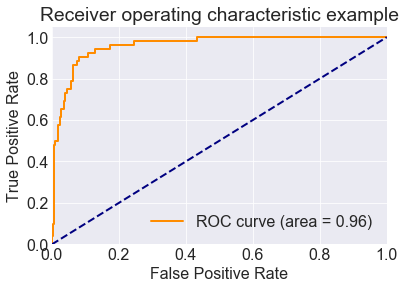

In [364]:
plt.figure()
lw = 2
plt.plot(fpr[2], tpr[2], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[2])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

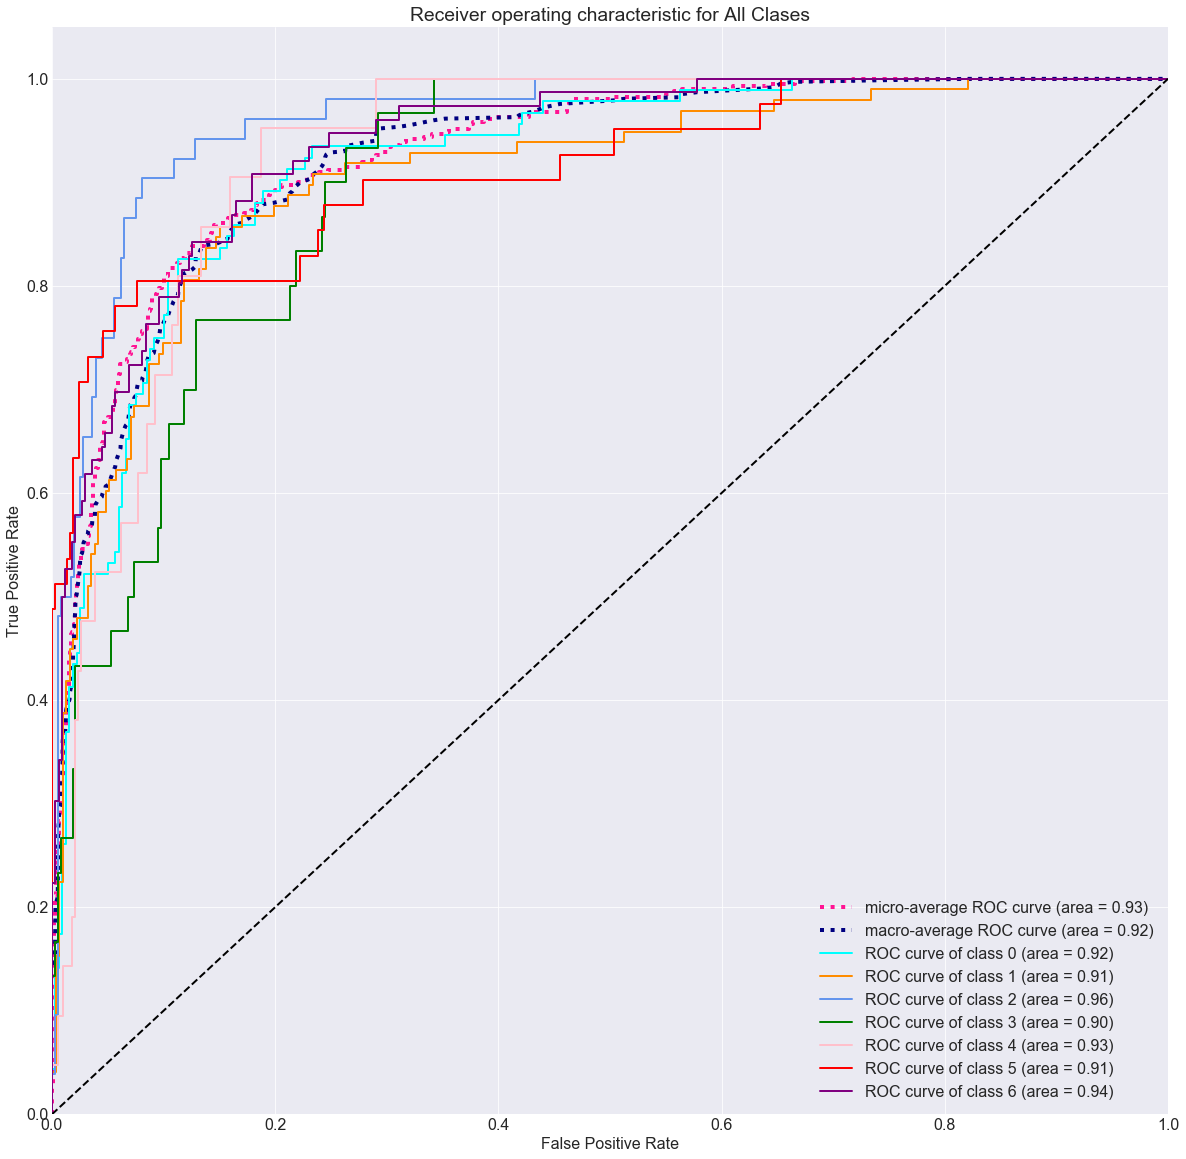

In [378]:
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize=(20,20))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = ['aqua', 'darkorange', 'cornflowerblue','green','pink','red', 'purple']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.rcParams.update({'font.size': 16})    
plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for All Clases')
plt.legend(loc="lower right")
plt.savefig('roc_wip.jpeg')
plt.show()